In [1]:
import re
from glob import glob
from pathlib import Path

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from randomise_prep import setup_randomise_tfce

from survey_medley_code.config_loader import load_config


# Setting up group F-test code
Here I'll just set up the randomise code.  I'll use a different notebook to aggregate and review the results.

In [2]:
cfg = load_config()

In [4]:
mask_path = (
    cfg.output_root / 'assess_subject_bold_dropout/group_mask_intersection_30pct.nii.gz'
)
question_output_path = (
    cfg.output_root / 'within_subject_question_estimates/within_subject_results'
)
outlier_assessment = question_output_path / 'outlier_assessment'

In [5]:
sub_id = []
bold_paths = []
questionnaire = []

questionnaire_names = ['grit', 'brief', 'future_time', 'impulsive_venture', 'upps']

for questionnaire_name in questionnaire_names:
    good_sub_file = (
        outlier_assessment
        / f'subjects_outlier_percent_lt_8_contrast_{questionnaire_name}.txt'
    )
    good_subs_list = good_sub_file.read_text().splitlines()
    for good_sub in good_subs_list:
        sub_no_s = good_sub.replace('s', '')
        # Glob for matching files
        bold_paths_loop = list(
            question_output_path.glob(
                f'{sub_no_s}/contrast_*{questionnaire_name}_effect_size_sub_{sub_no_s}.nii.gz'
            )
        )
        if bold_paths_loop:
            sub_id.append(sub_no_s)
            questionnaire.append(questionnaire_name)
            bold_paths.append(bold_paths_loop[0])  # take the first match
        else:
            print(
                f'Output file missing for question/subject: {questionnaire_name}/{good_sub}'
            )


In [7]:
df = pd.DataFrame({'subid': sub_id, 'questionnaire': questionnaire})

# --- Step 2: Build design matrix ---
unique_subs = sorted(df['subid'].unique())
num_subs = len(unique_subs)

# --- Subject indicators ---
for s in unique_subs:
    df[s] = np.where(df['subid'] == s, 1, 0)

# --- Question contrasts (vs Q01 / 'brief') ---
for q in questionnaire_names:
    if 'brief' not in q:
        df[q] = np.where(
            df['questionnaire'] == q, 1, np.where(df['questionnaire'] == 'brief', -1, 0)
        )

# Remove the original columns
desmat_df = df.drop(columns=['subid', 'questionnaire'])


/tmp/ipykernel_21623/1407857464.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[q] = np.where(


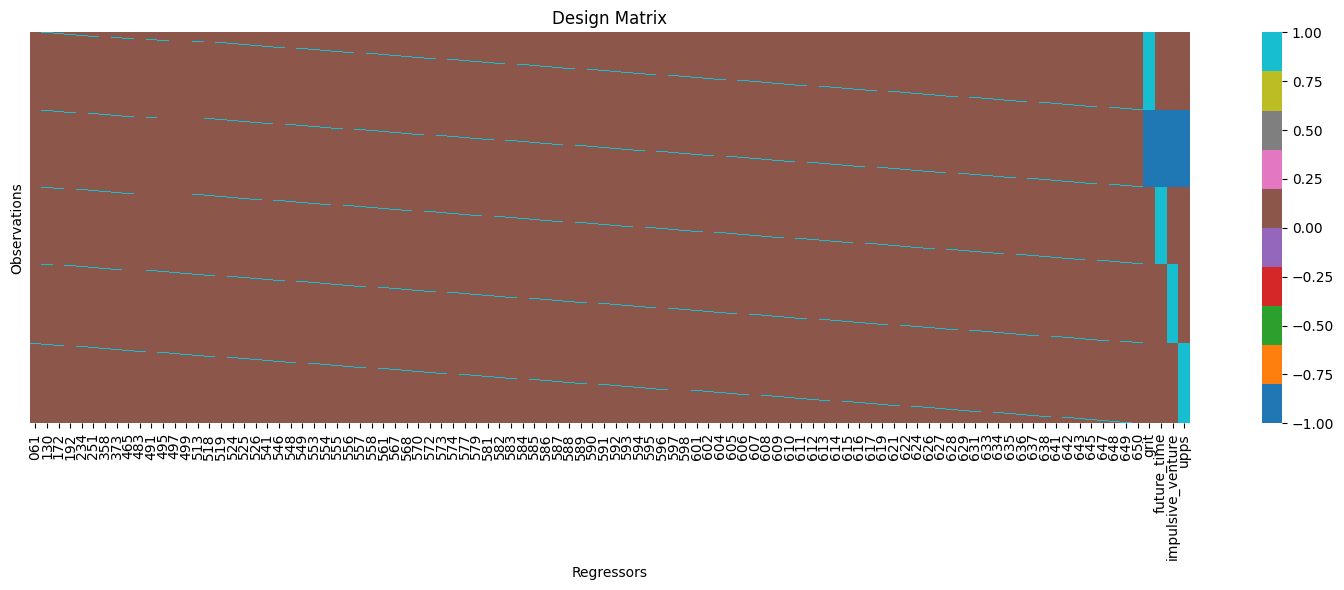

In [10]:
plt.figure(figsize=(15, 6))
sns.heatmap(
    desmat_df, xticklabels=desmat_df.columns, yticklabels=False, cmap='tab10'
)  # ensures only -1,0,1 are mapped

plt.title('Design Matrix')
plt.xlabel('Regressors')
plt.ylabel('Observations')
plt.tight_layout()
plt.show()

In [8]:
from pprint import pprint

contrasts = {}

qn = questionnaire_names

for i, q1 in enumerate(qn):
    if 'brief' not in q1:
        # always add q1 vs brief
        contrasts[f'{q1}-brief'] = q1
        # only iterate over items *after* q1
        for q2 in qn[i + 1 :]:
            if 'brief' not in q2:
                contrasts[f'{q1}-{q2}'] = f'{q1} - {q2}'

pprint(contrasts)

f_test = {
    'omnibusf': [
        f'{questionnaire}-brief'
        for questionnaire in questionnaire_names
        if 'brief' not in questionnaire
    ]
}

# for key, value in contrasts.items():
#     f_test[key] = [key]

print('f tests')
pprint(f_test)

{'future_time-brief': 'future_time',
 'future_time-impulsive_venture': 'future_time - impulsive_venture',
 'future_time-upps': 'future_time - upps',
 'grit-brief': 'grit',
 'grit-future_time': 'grit - future_time',
 'grit-impulsive_venture': 'grit - impulsive_venture',
 'grit-upps': 'grit - upps',
 'impulsive_venture-brief': 'impulsive_venture',
 'impulsive_venture-upps': 'impulsive_venture - upps',
 'upps-brief': 'upps'}
f tests
{'omnibusf': ['grit-brief',
              'future_time-brief',
              'impulsive_venture-brief',
              'upps-brief']}


In [16]:
output_glm_ftest = cfg.output_root / 'within_subject_question_estimates/group_f_test'

# script_path = setup_randomise_tfce(
#     input_files=bold_paths,
#     group_mask=mask_path,
#     output_directory=output_glm_ftest,
#     analysis_type='glm',
#     num_perm=2,
#     design_matrix=desmat_df,
#     contrast=contrasts,
#     ftest=f_test,
#     rename_output=True,
#     clear_output_dir=True,
# )

Clearing contents of output_directory: '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/group_f_test'
Concatenating input files...
Created 4D file: /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/group_f_test/input_data4d.nii.gz


### Note, I manually changed the randomise call
I added the `-e design.grp` to the call as well as the `--fonly` flag (no need to run t-tests)

I'm also going to add a second randomise call (since --fonly will suspend the t-stat computation) with `-R` to run only the regression.  This will give me uncorrected tstat images to work with.

In [17]:
# add a design.grp file
# unique_subs = sorted(df['subid'].unique())
# subid_map = {sub: i + 1 for i, sub in enumerate(unique_subs)}  # 1-based integers
# subid_ints = df['subid'].map(subid_map)

# # --- Step 2: Write to F-test text file ---
# output_file = output_glm_ftest / 'design.grp'
# output_file.parent.mkdir(parents=True, exist_ok=True)

# with output_file.open('w') as f:
#     f.write('/NumWaves 1\n')
#     f.write(f'/NumPoints {len(df["subid"])}\n')
#     f.write('\n')  # blank line
#     f.write('/Matrix\n')
#     for val in subid_ints:
#         f.write(f'{val}\n')

### Set up individual pairwise comaparisons
Including in the last model would have taken forever to run (5000 permutation took about 5 hours for just one F contrast)

In [9]:
print(sub_id[:10])
print(bold_paths[:10])
print(questionnaire[:10])

['130', '172', '192', '234', '251', '358', '373', '465', '491', '495']
[PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results/130/contrast_grit_effect_size_sub_130.nii.gz'), PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results/172/contrast_grit_effect_size_sub_172.nii.gz'), PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results/192/contrast_grit_effect_size_sub_192.nii.gz'), PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results/234/contrast_grit_effect_size_sub_234.nii.gz'), PosixPath('/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/within_subject_results/251/co

In [11]:
from itertools import combinations

import nibabel as nib
import numpy as np

# Directory for outputs
base_out = Path(
    '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/'
    'survey_medley_results/within_subject_question_estimates/'
    'all_paired_t_tests/paired_differences'
)

# -----------------------------------------------------
# BUILD A LOOKUP:  (sub, questionnaire) → file path
# -----------------------------------------------------

lookup = {}
for sid, qp, qname in zip(sub_id, bold_paths, questionnaire):
    lookup[(sid, qname)] = qp

# All questionnaire names present
questionnaire_names = sorted(set(questionnaire))

# -----------------------------------------------------
# LOOP OVER ALL QUESTIONNAIRE PAIRS
# -----------------------------------------------------
for qa, qb in combinations(questionnaire_names, 2):
    pairing_name = f'{qa}_minus_{qb}'
    outdir = base_out / pairing_name
    outdir.mkdir(parents=True, exist_ok=True)

    print(f'Processing pairing: {pairing_name}')

    # For every subject, check whether both images exist
    for sid in sub_id:
        keyA = (sid, qa)
        keyB = (sid, qb)

        if keyA not in lookup or keyB not in lookup:
            continue  # skip subjects missing data

        imgA = nib.load(str(lookup[keyA]))
        imgB = nib.load(str(lookup[keyB]))

        diff = imgA.get_fdata() - imgB.get_fdata()

        # Save output file
        out_path = outdir / f'{pairing_name}_{sid}.nii.gz'

        nib.Nifti1Image(diff, imgA.affine, imgA.header).to_filename(str(out_path))

        print(f'  Saved {out_path}')


Processing pairing: brief_minus_future_time
  Saved /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/all_paired_t_tests/paired_differences/brief_minus_future_time/brief_minus_future_time_130.nii.gz
  Saved /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/all_paired_t_tests/paired_differences/brief_minus_future_time/brief_minus_future_time_172.nii.gz
  Saved /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/all_paired_t_tests/paired_differences/brief_minus_future_time/brief_minus_future_time_192.nii.gz
  Saved /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/all_paired_t_tests/paired_differences/brief_minus_future_time/brief_minus_future_time_234.nii.gz
  Saved /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/wi

In [ ]:
script_path = setup_randomise_tfce(
    input_files=bold_paths_loop,
    group_mask=mask_path,
    output_directory=output_paired_ttest_loop,
    analysis_type='onesample_2sided',
    num_perm=5000,
    rename_output=True,
)

In [14]:
base_dir = Path(
    '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates'
)
paired_diff_root = base_dir / 'all_paired_t_tests' / 'paired_differences'
randomise_root = base_dir / 'all_paired_t_tests'

for q1, q2 in combinations(questionnaire_names, 2):
    # --------------------------------------------
    # 1. Build the pairing name and collect files
    # --------------------------------------------
    pair_name = f'{q1}_minus_{q2}'
    diff_dir = paired_diff_root / pair_name

    bold_paths_loop = sorted(diff_dir.glob('*.nii.gz'))
    if not bold_paths_loop:
        print(f'⚠️ No paired difference images found for {pair_name}, skipping.')
        continue

    print(f'Found {len(bold_paths_loop)} paired images for {pair_name}')

    # --------------------------------------------
    # 2. Build output randomise directory
    # --------------------------------------------
    output_paired_ttest_loop = randomise_root / f'paired_test_{pair_name}'
    output_paired_ttest_loop.mkdir(parents=True, exist_ok=True)

    # --------------------------------------------
    # 3. Run TFCE randomise job
    # --------------------------------------------
    script_path = setup_randomise_tfce(
        input_files=bold_paths_loop,
        group_mask=mask_path,  # already defined earlier
        output_directory=output_paired_ttest_loop,
        analysis_type='onesample_2sided',
        num_perm=5000,
        rename_output=True,
    )

    print(f'✓ Created randomise script for {pair_name}: {script_path}')

Found 90 paired images for brief_minus_future_time
Concatenating input files...
Created 4D file: /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/all_paired_t_tests/paired_test_brief_minus_future_time/input_data4d.nii.gz
Note: rename_output=True will rename _corrp_ to _1minuspvalue_ in output filenames for t-test analysis
✓ Created randomise script for brief_minus_future_time: /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/all_paired_t_tests/paired_test_brief_minus_future_time/randomise_call.sh
Found 91 paired images for brief_minus_grit
Concatenating input files...
Created 4D file: /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_question_estimates/all_paired_t_tests/paired_test_brief_minus_grit/input_data4d.nii.gz
Note: rename_output=True will rename _corrp_ to _1minuspvalue_ in output filenames for t-test analysis